In [1]:
import pandas as pd
import csv
import pyarrow.parquet as pq
import numpy as np
import os
import json


In [2]:
max_left_hand_index = 20
max_right_hand_index = 20
max_pose_index = 32

In [3]:
left_hand_columns = [f"left_hand_{i}" for i in range(max_left_hand_index + 1)]
right_hand_columns = [f"right_hand_{i}" for i in range(max_right_hand_index + 1)]
pose_columns = [f"pose_{i}" for i in range(max_pose_index + 1)]


# Combine all column headers into a single list
all_columns = [f"{col}_{coord}" for col in left_hand_columns for coord in ['x', 'y','z']] + \
              [f"{col}_{coord}" for col in right_hand_columns for coord in ['x', 'y','z']] + \
              [f"{col}_{coord}" for col in pose_columns for coord in ['x', 'y','z']] + \
              ['label']


In [4]:
train_df = pd.read_csv('Dataset_CSVs/train.csv')

In [5]:
selected_words = ["TV", "after",  "all", "alligator", "animal", "another", "any", "apple", "arm"]
# selected_words = ["TV", "after", "airplane", "all", "alligator"]

# Filter the dataframe to include only the selected words
filtered_df = train_df[train_df['sign'].isin(selected_words)]

# Group by 'sign' and select 10 sequences for each word
sub_df = filtered_df.groupby('sign').head(15)

In [6]:


# Initialize an empty list to store all rows of data
all_rows = []

# Iterate through each row in sub_df
for index, row in sub_df.iterrows():
    path = row['path']
    label = row['sign']
    
    # Read the Parquet file using PyArrow
    table = pq.read_table(path)
    
    # Convert PyArrow Table to Pandas DataFrame
    df = table.to_pandas()
    
    # Initialize a list to store rows of data
    rows = []
    
    # Iterate through each unique frame
    for frame in df['frame'].unique():
        # Filter rows for the current frame
        subset_df = df[df['frame'] == frame]
        
        # Initialize dictionaries to store landmarks
        face_dict = {}
        left_hand_dict = {}
        right_hand_dict = {}
        pose_dict = {}
        
        # Iterate through rows in subset_df and populate dictionaries
        for idx, row in subset_df.iterrows():
            landmark_type = row['type']
            landmark_index = row['landmark_index']
            x = row['x']
            y = row['y']
            z = row['z']
            
            if landmark_type == 'left_hand':
                left_hand_dict[f"left_hand_{landmark_index}_x"] = x
                left_hand_dict[f"left_hand_{landmark_index}_y"] = y
                left_hand_dict[f"left_hand_{landmark_index}_z"] = z
            elif landmark_type == 'right_hand':
                right_hand_dict[f"right_hand_{landmark_index}_x"] = x
                right_hand_dict[f"right_hand_{landmark_index}_y"] = y
                right_hand_dict[f"right_hand_{landmark_index}_z"] = z
            elif landmark_type == 'pose':
                pose_dict[f"pose_{landmark_index}_x"] = x
                pose_dict[f"pose_{landmark_index}_y"] = y
                pose_dict[f"pose_{landmark_index}_z"] = z
        
        # Combine dictionaries into a single row of data
        row_data = {
            **left_hand_dict,
            **right_hand_dict,
            **pose_dict,
            'label': label,
        }
        
        # Append row_data to rows list
        rows.append(row_data)
    
    # Extend rows to all_rows
    all_rows.extend(rows)

# Define CSV file path
csv_file = 'Dataset_CSVs/ASL_word_data_xyz.csv'

# Define column headers as the union of keys from all row_data dictionaries
# header = ['frame'] + sorted(set().union(*(row.keys() for row in all_rows)))

# Write rows to CSV file
with open(csv_file, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=all_columns)
    writer.writeheader()
    
    # Iterate through all_rows and write each row to CSV
    for row_data in all_rows:
        # Round numerical values to 3 decimal places
        rounded_row_data = {key: round(value, 6) if isinstance(value, (int, float)) else value for key, value in row_data.items()}
        
        # Replace NaN values with 0.0
        cleaned_row_data = {key: (0.0 if pd.isna(value) else value) for key, value in rounded_row_data.items()}
        
        # Write the row to CSV
        writer.writerow(cleaned_row_data)

print(f"Data has been successfully written to {csv_file}")


Data has been successfully written to Dataset_CSVs/ASL_word_data_xyz.csv


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mediapipe as mp

# Load the data from the CSV file
df = pd.read_csv('Dataset_CSVs/ASL_word_data_xyz.csv')

# Define landmark columns
left_hand_columns = [f"left_hand_{i}" for i in range(21)]
right_hand_columns = [f"right_hand_{i}" for i in range(21)]
pose_columns = [f"pose_{i}" for i in range(33)]

left_hand_coords = [f"{col}_{coord}" for col in left_hand_columns for coord in ['x', 'y']]
right_hand_coords = [f"{col}_{coord}" for col in right_hand_columns for coord in ['x', 'y', 'z']]
pose_coords = [f"{col}_{coord}" for col in pose_columns for coord in ['x', 'y', 'z']]



In [2]:

# Extract left hand coordinates and reshape into array
left_hand_coords_array = df[left_hand_coords].values.reshape(-1, 2)

In [3]:
left_hand_coords_array

array([[0.748716, 0.741321],
       [0.621914, 0.719244],
       [0.556285, 0.679997],
       [0.534262, 0.63844 ],
       [0.539414, 0.603286],
       [0.615002, 0.580789],
       [0.537981, 0.572434],
       [0.538763, 0.621508],
       [0.571877, 0.652171],
       [0.637226, 0.571116],
       [0.548088, 0.567712],
       [0.549698, 0.621983],
       [0.584102, 0.652726],
       [0.658923, 0.56835 ],
       [0.556113, 0.570421],
       [0.563516, 0.627174],
       [0.602569, 0.656123],
       [0.676836, 0.575986],
       [0.576764, 0.5778  ],
       [0.580324, 0.626662],
       [0.616504, 0.656087]])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

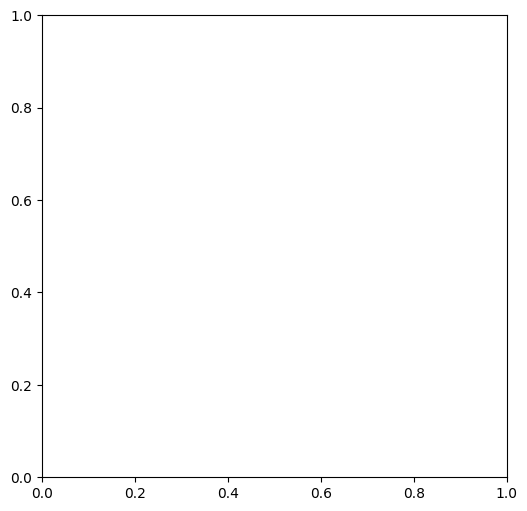

In [4]:
# MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils

# Function to plot left hand landmarks using MediaPipe drawing techniques
def plot_left_hand_mediapipe(landmarks):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Draw connections between keypoints
    mp_drawing.draw_landmarks(
        ax, landmarks, mp.solutions.holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=None, connection_drawing_spec=None
    )
    ax.set_title('Left Hand Landmarks')
    ax.set_aspect('equal')
    ax.invert_yaxis()  # Invert Y axis to match the MediaPipe coordinate system
    plt.show()

# Example usage: Plot the left hand landmarks
plot_left_hand_mediapipe(left_hand_coords_array)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

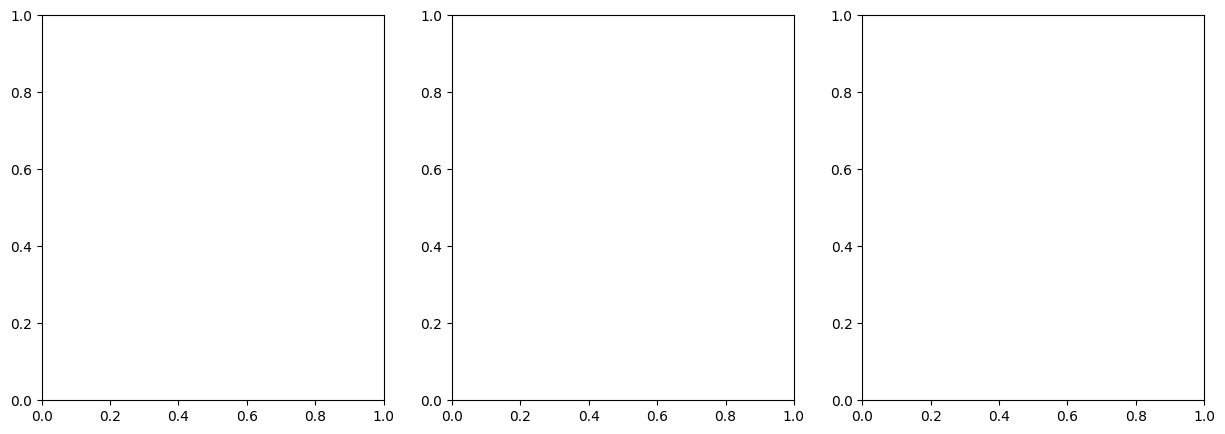

In [5]:
# MediaPipe drawing utilities
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

def plot_landmarks_mediapipe(ax, landmarks, connections, title):
    # Check if landmarks array is not empty
    if landmarks.any():
        # Draw connections between keypoints
        mp_drawing.draw_landmarks(
            ax, landmarks, connections,
            landmark_drawing_spec=None, connection_drawing_spec=None
        )
        ax.set_title(title)
        ax.set_aspect('equal')
        ax.invert_yaxis()  # Invert Y axis to match the MediaPipe coordinate system
    else:
        ax.set_title(title + ' (Empty)')
        ax.axis('off')

def plot_row_mediapipe(row):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot left hand
    left_hand = row[left_hand_coords].values.reshape(-1, 3)
    plot_landmarks_mediapipe(axs[0], left_hand, mp_holistic.HAND_CONNECTIONS, 'Left Hand')
    
    # Plot right hand
    right_hand = row[right_hand_coords].values.reshape(-1, 3)
    plot_landmarks_mediapipe(axs[1], right_hand, mp_holistic.HAND_CONNECTIONS, 'Right Hand')
    
    # Plot pose
    pose = row[pose_coords].values.reshape(-1, 3)
    plot_landmarks_mediapipe(axs[2], pose, mp_holistic.POSE_CONNECTIONS, 'Pose')
    
    plt.tight_layout()
    plt.show()

# Plot each row of landmarks separately
for idx, row in df.iterrows():
    plot_row_mediapipe(row)

